In [45]:
# Import libs
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import os.path as osp 
from collections import defaultdict
from PIL import Image
import math 
from tqdm.notebook import tqdm 
import random

import torch 
from torch import nn 
import torch.nn.functional as F 
from torch import optim 
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary

import datetime

from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator

# Data preparation

## Combine 2 datasets together

In [2]:
stations = ['76t']

In [3]:
station_to_file = {'76t': 'data/PCD Data/Data before 2020-9/(76t)ศูนย์การศึกษานอกโรงเรียน จ.ตาก.xlsx'}

In [4]:
dfs1 = {}
for station in stations:
    dfs1[station] = pd.read_excel(station_to_file[station])

In [5]:
dfs1['76t'].head()

,ปี/เดือน/วัน,ชั่วโมง,PM10,PM2.5,CO,NO2,O3,WS,WD,TEMP,RH
0,NaN,NaN,at 3 m (มคก./ลบ.ม.),at 3 m (มคก./ลบ.ม.),at 3 m (ppm),at 3 m (ppb),at 3 m (ppb),at 10 m (m/s),at 10 m (Deg.M),at 3 m,at 3 m (%RH)
1,160601.0,100.0,12,2,0.2,0,9,0,NaN,26,85
2,160601.0,200.0,15,4,0.3,0,8,0.3,217,25.7,87
3,160601.0,300.0,12,4,0.2,0,5,0.2,111,25.5,88
4,160601.0,400.0,18,4,0.3,0,5,0.1,NaN,25.6,87


In [6]:
def process_data_before(df):
    df = df.iloc[1:,:]
    df = df.drop(['PM10', 'CO', 'NO2', 'O3', 'WS', 'WD', 'TEMP', 'RH'], axis=1)
    df['Date'] = pd.to_datetime(df['ปี/เดือน/วัน'], format='%y%m%d')
    df['ชั่วโมง'] = df['ชั่วโมง'].apply(lambda x: 0 if int(x) == 2400 else x)
    df.loc[df['ชั่วโมง'] == 0, 'Date'] += datetime.timedelta(days=1)
    df['Time'] = df['ชั่วโมง'].astype('str')
    df['Time'] = df['Time'].apply(lambda x: x[:-2].zfill(4))
    df['Datetime'] = pd.to_datetime(df['Date'].astype('str') + ' ' +df['Time'], format='%Y-%m-%d %H%M')
    df = df.drop(['Time', 'Date', 'ปี/เดือน/วัน', 'ชั่วโมง'], axis=1)
    df = df.set_index('Datetime').sort_index()
    df = df[df.index < '2020-07-20 19:00:00']
    df['PM2.5'] = df['PM2.5'].replace('-', np.nan)
    return df

In [7]:
process_data_before(dfs1['76t']).tail()

,PM2.5
Datetime,
2020-07-20 14:00:00,5.0
2020-07-20 15:00:00,4.0
2020-07-20 16:00:00,9.0
2020-07-20 17:00:00,7.0
2020-07-20 18:00:00,4.0


In [8]:
df2 = pd.read_csv('data/PCD Data/Data after 2020-7/PCD data after 2020-7.csv')

In [9]:
dfs2 = {}
for station in stations:
    dfs2[station] = df2[df2['stationID'] == '76t']

In [10]:
dfs2['76t'].head()

,id,stationID,nameTH,nameEN,stationType,lat,long,date_aq,time_aq,PM25,PM10,NO2,SO2,CO,O3,AQI,areaTH,areaEN,datetime_aq
0,515454,76t,ศูนย์การศึกษานอกโรงเรียน,"Non-Formal Education Centre, Mea Sot",GROUND,16.750102,98.591312,2020-07-20,21:00:00,8.0,22.0,4.0,NaN,0.13,13.0,1,"ต.แม่ปะ อ.แม่สอด, ตาก","MaePa, MaeSot, Tak",2020-07-20 21:00:00.000
87,515583,76t,ศูนย์การศึกษานอกโรงเรียน,"Non-Formal Education Centre, Mea Sot",GROUND,16.750102,98.591312,2020-07-20,22:00:00,8.0,22.0,4.0,NaN,0.13,12.0,1,"ต.แม่ปะ อ.แม่สอด, ตาก","MaePa, MaeSot, Tak",2020-07-20 22:00:00.000
226,515712,76t,ศูนย์การศึกษานอกโรงเรียน,"Non-Formal Education Centre, Mea Sot",GROUND,16.750102,98.591312,2020-07-20,23:00:00,8.0,22.0,4.0,NaN,0.17,11.0,1,"ต.แม่ปะ อ.แม่สอด, ตาก","MaePa, MaeSot, Tak",2020-07-20 23:00:00.000
394,515196,76t,ศูนย์การศึกษานอกโรงเรียน,"Non-Formal Education Centre, Mea Sot",GROUND,16.750102,98.591312,2020-07-20,19:00:00,8.0,22.0,3.0,NaN,0.12,15.0,1,"ต.แม่ปะ อ.แม่สอด, ตาก","MaePa, MaeSot, Tak",2020-07-20 19:00:00.000
512,515325,76t,ศูนย์การศึกษานอกโรงเรียน,"Non-Formal Education Centre, Mea Sot",GROUND,16.750102,98.591312,2020-07-20,20:00:00,8.0,22.0,4.0,NaN,0.13,14.0,1,"ต.แม่ปะ อ.แม่สอด, ตาก","MaePa, MaeSot, Tak",2020-07-20 20:00:00.000


In [11]:
def process_data_after(df):
    df = df.drop(['id', 'stationID', 'nameTH', 'nameEN', 'stationType', 'lat', 'long', 'date_aq', 'time_aq', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'AQI','areaTH', 'areaEN'], axis=1)
    df['Datetime'] = pd.to_datetime(df['datetime_aq'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index('Datetime').sort_index()
    df = df.rename(columns={'PM25': 'PM2.5'})
    df = df.drop(['datetime_aq'], axis=1)
    return df

In [12]:
process_data_after(dfs2['76t']).head()

,PM2.5
Datetime,
2020-07-20 19:00:00,8.0
2020-07-20 20:00:00,8.0
2020-07-20 21:00:00,8.0
2020-07-20 22:00:00,8.0
2020-07-20 23:00:00,8.0


In [13]:
dfs = {}
for station in stations:
    dfs[station] = pd.concat((process_data_before(dfs1[station]), process_data_after(dfs2[station])))

In [14]:
dfs['76t']

,PM2.5
Datetime,
2016-06-01 01:00:00,2.0
2016-06-01 02:00:00,4.0
2016-06-01 03:00:00,4.0
2016-06-01 04:00:00,4.0
2016-06-01 05:00:00,7.0
...,...
2022-01-30 14:00:00,35.0
2022-01-30 15:00:00,36.0
2022-01-30 16:00:00,37.0


## Impute missing value

In [15]:
for station in stations:
    dfs[station] = dfs[station].ffill()
    # dfs[station]['PM2.5'] = dfs[station]['PM2.5'].astype('int')

## Add feature

In [16]:
for station in stations:
    dfs[station]['Weekcos'] = np.cos(2 * np.pi * (dfs[station].index.month -1) /11)
    dfs[station]['Weeksin'] = np.sin(2 * np.pi * (dfs[station].index.month -1) /11)

## Add timestep

In [17]:
def add_timestep(df, timestep):
    xs = []
    ys = []
    for i in range(df.shape[0]-timestep-1):
        x = df.iloc[i:i+timestep, :].to_numpy()
        y = df.iloc[i+timestep, 0]
        xs.append(x.astype(np.float32))
        ys.append(y.astype(np.float32))
    return xs, ys

In [18]:
xs, ys = add_timestep(dfs['76t'], 12)

In [19]:
class PMDataset(Dataset): 
  def __init__(self, xs, ys):
    self.xs = np.array(xs)
    self.ys = np.array(ys).reshape(-1,1)
  
  def __len__(self):
    return len(self.xs)
  
  def __getitem__(self, idx): 
    x = self.xs[idx]
    y = self.ys[idx]
    return x, y

In [20]:
xs, ys = add_timestep(dfs['76t'], 12)
dataset = PMDataset(xs, ys)

In [21]:
def df_to_dataset(df, timestep, batch_size):
    xs, ys = add_timestep(df, timestep)
    dataset = PMDataset(xs, ys)
    return DataLoader(dataset, batch_size, shuffle=False, pin_memory=True)

In [22]:
train_dataloaders = {}
val_dataloaders = {}
test_dataloaders = {}
time_step = 12
batch_size = 32
for station in stations:
    temp = dfs[station]
    train = temp[temp.index < '2019-06-01']
    val = temp[('2019-06-01' <= temp.index) & (temp.index < '2020-06-01')]
    test = temp[temp.index >= '2020-06-01']
    train_dataloaders[station] = df_to_dataset(train, time_step, batch_size)
    val_dataloaders[station] = df_to_dataset(val, time_step, batch_size)
    test_dataloaders[station] = df_to_dataset(test, time_step, batch_size)


In [23]:
for x, y in train_dataloaders['76t']:
    print(x.type())
    print(y.type())
    print(x.shape)
    print(y.shape)
    break

torch.FloatTensor
torch.FloatTensor
torch.Size([32, 12, 3])
torch.Size([32, 1])


# Model

## Initialize model

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
class PMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, drop_prob=0.2):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = torch.zeros(size=(self.n_layers, len(x), self.hidden_dim)).cuda()
        y, _ = self.gru(x, h)
        y = self.fc(y[:, -1])
        y = self.relu(y)
        return y


In [26]:
input_dim = dfs['76t'].shape[1]
hidden_dim = 512
n_layers = 5

pm_model = PMModel(input_dim, hidden_dim, n_layers)
pm_model = pm_model.to(device)

In [27]:
temp_time_step = 12
summary(pm_model, input_size=(batch_size,temp_time_step,input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
PMModel                                  --                        --
├─GRU: 1-1                               [32, 12, 512]             7,097,856
├─Linear: 1-2                            [32, 1]                   513
├─ReLU: 1-3                              [32, 1]                   --
Total params: 7,098,369
Trainable params: 7,098,369
Non-trainable params: 0
Total mult-adds (G): 2.73
Input size (MB): 0.00
Forward/backward pass size (MB): 1.57
Params size (MB): 28.39
Estimated Total Size (MB): 29.97

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(pm_model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1, min_lr=1e-8)

## Training

In [29]:
num_epochs = 20

train_losses = []
val_losses = []
min_val_loss = float('inf')

os.makedirs('weights', exist_ok=True)
best_weights_path = 'weights/best_weights.pth'

station = '76t'

for epoch in tqdm(range(num_epochs)):
    pm_model.train()
    total_train_loss = 0

    for x, y in train_dataloaders[station]:
        x = x.type(torch.FloatTensor).to(device)
        y = y.type(torch.FloatTensor).to(device)
        pm_model.zero_grad()

        out = pm_model(x)
        train_loss = criterion(out, y)
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()

    current_train_loss = total_train_loss / len(train_dataloaders[station])
    train_losses.append(current_train_loss)

    total_val_loss = 0
    pm_model.eval()
    with torch.no_grad():
        for val_x, val_y in val_dataloaders[station]:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_out = pm_model(val_x)

            val_loss = criterion(val_out, val_y)
            total_val_loss += val_loss.item()

    current_val_loss = total_val_loss / len(val_dataloaders[station])
    val_losses.append(current_val_loss)
    if current_val_loss < min_val_loss: 
        min_val_loss = current_val_loss 
        torch.save(pm_model.state_dict(), best_weights_path)
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Val loss = {current_val_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {optimizer.param_groups[0]["lr"]:.8f}') 
    scheduler.step(current_val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 - Train loss = 624.0183 - Val loss = 703.5158 - best min_val_loss = 703.5158 - lr = 0.00005000
Epoch 2 - Train loss = 597.0691 - Val loss = 463.2868 - best min_val_loss = 463.2868 - lr = 0.00005000
Epoch 3 - Train loss = 328.1723 - Val loss = 337.1738 - best min_val_loss = 337.1738 - lr = 0.00005000
Epoch 4 - Train loss = 258.9071 - Val loss = 260.0247 - best min_val_loss = 260.0247 - lr = 0.00005000
Epoch 5 - Train loss = 214.8470 - Val loss = 207.9218 - best min_val_loss = 207.9218 - lr = 0.00005000
Epoch 6 - Train loss = 184.9727 - Val loss = 172.7352 - best min_val_loss = 172.7352 - lr = 0.00005000
Epoch 7 - Train loss = 163.7462 - Val loss = 149.2818 - best min_val_loss = 149.2818 - lr = 0.00005000
Epoch 8 - Train loss = 147.9592 - Val loss = 133.0853 - best min_val_loss = 133.0853 - lr = 0.00005000
Epoch 9 - Train loss = 136.6510 - Val loss = 120.2605 - best min_val_loss = 120.2605 - lr = 0.00005000
Epoch 10 - Train loss = 127.9217 - Val loss = 107.7657 - best min_val_los

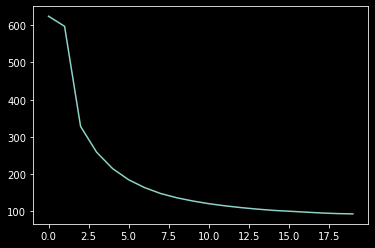

In [30]:
plt.plot(train_losses)
plt.show()

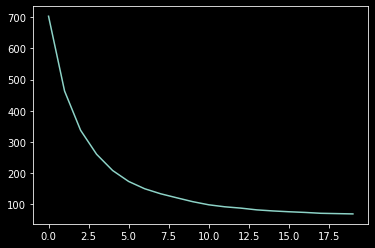

In [31]:
plt.plot(val_losses)
plt.show()

## Evaluate

In [42]:
pm_model.eval()
y_preds = np.array([])
y_true = np.array([])
with torch.no_grad():
    for x, y in test_dataloaders[station]:
        x = x.to(device)
        y_pred = pm_model(x)
        y_preds = np.concatenate((y_preds, y_pred.detach().cpu().numpy().flatten()))
        y_true = np.concatenate((y_true, y.numpy().flatten()))


In [46]:
np.sqrt(mean_squared_error(y_true, y_preds))

4.392443377781591

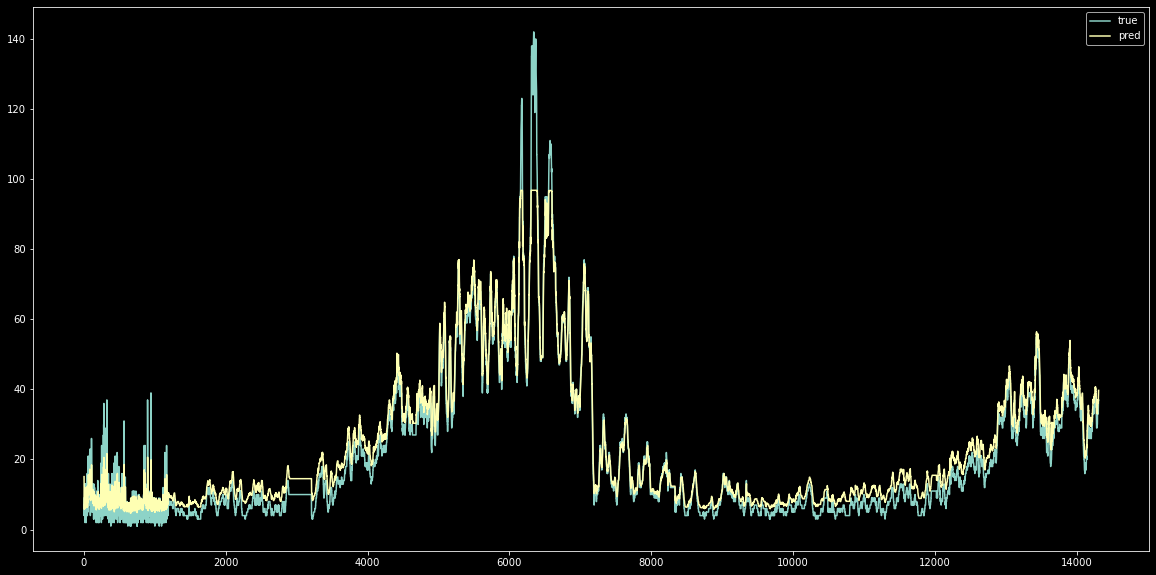

In [50]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(y_true))
plt.plot(x, y_true, label='true')
plt.plot(x, y_preds, label='pred')
plt.legend()
plt.show()